Linear Mixed Effects Model.

In [82]:
# import modules needed
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import sklearn as sk
import numpy as np
from numpy import mean
from numpy import median
from numpy import percentile
import glob

import statsmodels.api as sm
import statsmodels.formula.api as smf

import datetime as dt
from dateutil.relativedelta import relativedelta

from math import sqrt

import warnings
warnings.filterwarnings('ignore')

In [83]:
tadpoleD1D2File = 'TADPOLE_D1_D2.csv'

data_tadpole_all = pd.read_csv(tadpoleD1D2File, low_memory=False)
data_tadpole=data_tadpole_all[['RID','EXAMDATE','D1','D2','APOE4',
                       'MMSE','DXCHANGE', 'AGE', 
                       'ADAS13','Ventricles','Hippocampus','ICV_bl','Month_bl', 'Years_bl']].copy()

#Create Diagnosis variable based on DXCHANGE
idx_mci=data_tadpole['DXCHANGE']==4
data_tadpole.loc[idx_mci,'DXCHANGE']=2
idx_ad = data_tadpole['DXCHANGE']==5
data_tadpole.loc[idx_ad,'DXCHANGE']=3
idx_ad = data_tadpole['DXCHANGE']==6
data_tadpole.loc[idx_ad,'DXCHANGE']=3
idx_cn = data_tadpole['DXCHANGE']==7
data_tadpole.loc[idx_cn,'DXCHANGE']=1
idx_mci=data_tadpole['DXCHANGE']==8
data_tadpole.loc[idx_mci,'DXCHANGE']=2
idx_cn = data_tadpole['DXCHANGE']==9
data_tadpole.loc[idx_cn,'DXCHANGE']=1
data_tadpole=data_tadpole.rename(columns={'DXCHANGE':'Diagnosis'})

data_tadpole['Diagnosis'] = data_tadpole.Diagnosis.astype('category')

In [84]:
data_tadpole['startdate'] = dt.datetime(2018, 1, 1)
data_tadpole['EXAMDATE'] = pd.to_datetime(data_tadpole['EXAMDATE'])

In [85]:
data_tadpole['month_to_start'] = ((data_tadpole['startdate'] - data_tadpole['EXAMDATE'])/np.timedelta64(1, 'M'))

In [86]:
#correct ventricle volume
data_tadpole['Ventricles_ICV'] = data_tadpole['Ventricles'].values / data_tadpole['ICV_bl'].values

Subjects for prediction

In [87]:
#drop NaN
data_tadpole.dropna(subset = ['RID', 'Diagnosis', 'ICV_bl', 'Ventricles', 'ADAS13'],how='any',inplace=True)

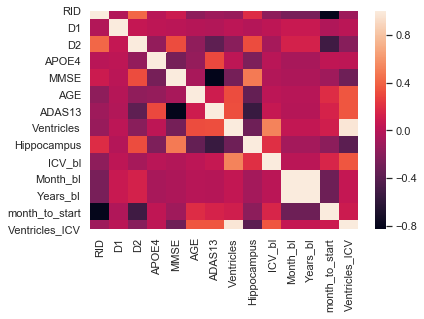

In [88]:
corr = data_tadpole.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

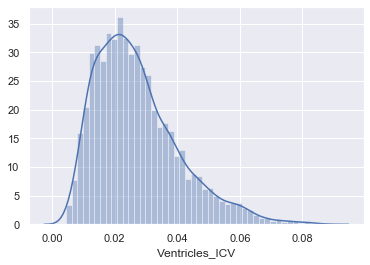

In [89]:
sns.distplot(data_tadpole.Ventricles_ICV)
plt.show()

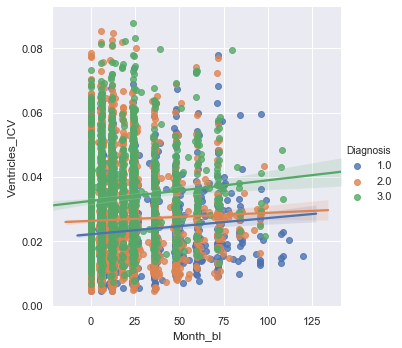

In [90]:
sns.lmplot(x = "Month_bl", y = "Ventricles_ICV", hue="Diagnosis", data = data_tadpole)

In [91]:
#Set Age for each point
data_tadpole['VISITAGE'] = data_tadpole['AGE'] + data_tadpole['Years_bl']

In [92]:
md = sm.MixedLM.from_formula("Ventricles_ICV ~ 1 + Month_bl+VISITAGE+ADAS13", re_formula="~1 + Month_bl", groups="RID", data=data_tadpole)
mdf = md.fit()
print(mdf.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: Ventricles_ICV
No. Observations:   6611    Method:             REML          
No. Groups:         1688    Scale:              0.0000        
Min. group size:    1       Likelihood:         27205.9185    
Max. group size:    11      Converged:          Yes           
Mean group size:    3.9                                       
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept          -0.026    0.002 -16.037 0.000 -0.029 -0.023
Month_bl            0.000    0.000  10.818 0.000  0.000  0.000
VISITAGE            0.001    0.000  30.731 0.000  0.001  0.001
ADAS13              0.000    0.000  16.456 0.000  0.000  0.000
RID Var             0.000    0.000                            
RID x Month_bl Cov  0.000    0.000                            
Month

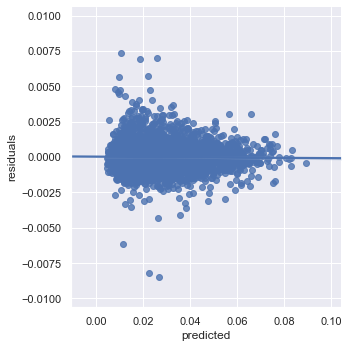

In [93]:
performance = pd.DataFrame()
performance["residuals"] = mdf.resid.values
performance["Month_bl"] = data_tadpole.Month_bl
performance["predicted"] = mdf.fittedvalues

sns.lmplot(x = "predicted", y = "residuals", data = performance)

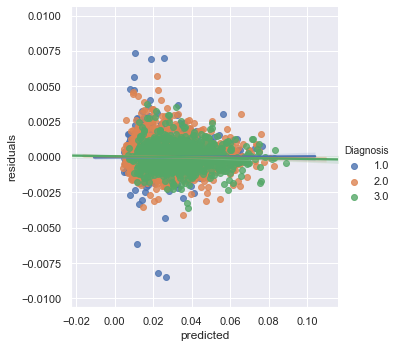

In [94]:
performance["Diagnosis"] = data_tadpole.Diagnosis
sns.lmplot(x = "predicted", y = "residuals", data = performance, hue='Diagnosis')

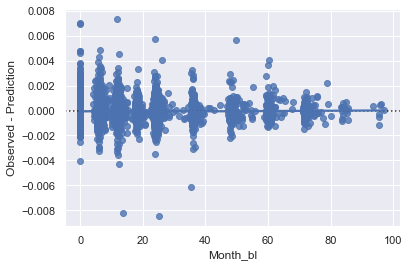

In [95]:
ax = sns.residplot(x = "Month_bl", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()

In [96]:
# and let's store the rmse
y = mdf.resid.values
y_predict = mdf.fittedvalues
RMSE = sqrt(((y-y_predict)**2).values.mean())

results = pd.DataFrame()
results["Method"] = ["Mixed"]
results["RMSE"] = RMSE
results

,Method,RMSE
0,Mixed,0.030083


In [97]:
print('Parameters: ', mdf.params['Month_bl'])
print('Standard errors: ', mdf.bse)
print('Predicted values: ', mdf.predict())


Parameters:  8.181789558101425e-05
Standard errors:  Intercept             0.001613
Month_bl              0.000008
VISITAGE              0.000022
ADAS13                0.000008
RID Var               0.218230
RID x Month_bl Cov    0.007870
Month_bl Var               NaN
dtype: float64
Predicted values:  [0.02653651 0.03292812 0.03361301 ... 0.03056219 0.02163338 0.02903744]


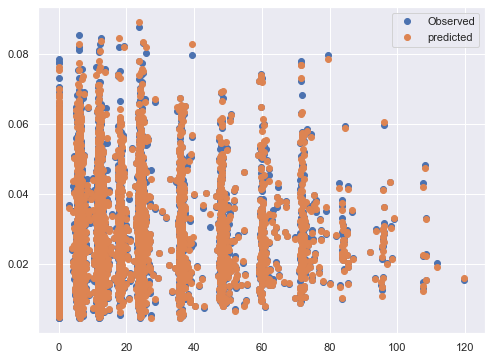

In [98]:
fig, ax = plt.subplots(figsize=(8,6))
x=data_tadpole["Month_bl"]
ax.plot(x, data_tadpole["Ventricles_ICV"], 'o', label="Observed")
ax.plot(x, mdf.fittedvalues, 'o', label="predicted")
#ax.plot(x, iv_u, 'r--')
#ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');

In [99]:
mdf.conf_int(0.5)

,0,1
Intercept,-0.026958,-0.024782
Month_bl,0.000077,0.000087
VISITAGE,0.000656,0.000685
ADAS13,0.000132,0.000143
RID Var,9.699362,9.993750
RID x Month_bl Cov,0.082517,0.093134
Month_bl Var,NaN,NaN


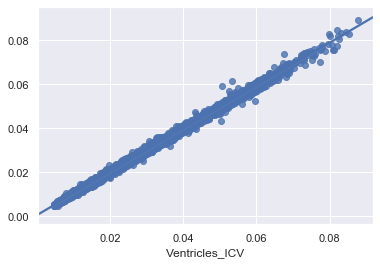

In [100]:
sns.regplot(x=data_tadpole["Ventricles_ICV"], y=mdf.fittedvalues, data=data_tadpole)

In [101]:
D2=data_tadpole['D2'].copy()
#Make list of RIDs in D2 to be predicted
idx_d2=D2==1
data_tadpole_RID = data_tadpole.loc[idx_d2,'RID']
SD2=pd.Series(np.unique(data_tadpole_RID.values))
#SD2.to_csv('ToPredict_D2.csv',index=False)

In [102]:
mdf_prediction = mdf.predict()
print(mdf_prediction)

[0.02653651 0.03292812 0.03361301 ... 0.03056219 0.02163338 0.02903744]


## Try a prediction at each timepoint (1-60 months)
add CI with bootstrapping, get predictions using only most recent timepoint for only subs in D2

In [103]:
forecast_month = 0
while (forecast_month < 60):
    forecast_month+=1
    data_tadpole['forecast_month']=forecast_month
    y_new_pred=mdf.predict(exog=dict(Month_bl=(data_tadpole['forecast_month']+data_tadpole['month_to_start']),VISITAGE=data_tadpole['VISITAGE'],ADAS13=data_tadpole['ADAS13']))
    y_new_pred_df=pd.DataFrame(columns=['RID','month_to_start','D2','new_prediction'])
    y_new_pred_df['RID']=data_tadpole['RID']
    y_new_pred_df['month_to_start'] = data_tadpole['month_to_start']
    y_new_pred_df['D2']=data_tadpole['D2']
    y_new_pred_df['new_prediction'] = y_new_pred
    
    

    # bootstrap
    #dataset = result.predict()
    dataset = y_new_pred_df["new_prediction"] #need to set to 
    # configure bootstrap
    n_iterations = 100 #set low for testing
    n_size = int(len(dataset) * 0.50)
    total_size = int(len(dataset))
    
    scores = list()
    for i in range(n_iterations):
        # bootstrap sample
        sample= np.random.choice(dataset,n_size)
        # calculate and store statistic
        statistic = mean(sample)
        scores.append(statistic)
    print('50th percentile (median) = %.6f' % median(scores))
    # calculate 50% confidence intervals (100 - alpha)
    alpha = 50.0
    # calculate lower percentile (e.g. 25)
    lower_p = alpha / 2.0
    # retrieve observation at lower percentile
    lower = max(0.0, percentile(scores, lower_p))
    print('%.1fth percentile = %.6f' % (lower_p, lower))
    # calculate upper percentile (e.g. 75)
    upper_p = (100 - alpha) + (alpha / 2.0)
    # retrieve observation at upper percentile
    upper = min(1.0, percentile(scores, upper_p))
    print('%.1fth percentile = %.6f' % (upper_p, upper))
    lower_dif=lower-statistic
    upper_dif=upper-statistic
    y_new_pred_df['Ventricles_ICV 50% CI lower']=y_new_pred_df['new_prediction']+lower_dif
    y_new_pred_df['Ventricles_ICV 50% CI upper']=y_new_pred_df['new_prediction']+upper_dif
    
    
    #keep only D2 subs
    y_new_pred_df=y_new_pred_df.loc[y_new_pred_df['D2'] == 1]
    
    #drop duplicate RID, keeping closest to challenge
    y_new_pred_df=y_new_pred_df.sort_values('month_to_start').drop_duplicates(subset='RID', keep='first')
    y_new_pred_df=y_new_pred_df.sort_values('RID')
    y_new_pred_df['Forecast Month']=forecast_month
    file_name=['month',str(forecast_month),'prediction.csv']
    y_new_pred_df.to_csv(("_".join(file_name)), index=False)
    

50th percentile (median) = 0.034651
25.0th percentile = 0.034590
75.0th percentile = 0.034709
50th percentile (median) = 0.034730
25.0th percentile = 0.034675
75.0th percentile = 0.034793
50th percentile (median) = 0.034820
25.0th percentile = 0.034742
75.0th percentile = 0.034880
50th percentile (median) = 0.034878
25.0th percentile = 0.034806
75.0th percentile = 0.034954
50th percentile (median) = 0.034956
25.0th percentile = 0.034898
75.0th percentile = 0.035041
50th percentile (median) = 0.035074
25.0th percentile = 0.034991
75.0th percentile = 0.035123
50th percentile (median) = 0.035132
25.0th percentile = 0.035056
75.0th percentile = 0.035225
50th percentile (median) = 0.035207
25.0th percentile = 0.035141
75.0th percentile = 0.035255
50th percentile (median) = 0.035288
25.0th percentile = 0.035218
75.0th percentile = 0.035370
50th percentile (median) = 0.035351
25.0th percentile = 0.035302
75.0th percentile = 0.035435
50th percentile (median) = 0.035464
25.0th percentile = 0.03

In [104]:
# * Create arrays to contain the 60 monthly forecasts for each D2 subject
nForecasts = 5 * 12  # forecast 5 years (60 months).

# * Submission dates - compare with submission template
startDate = dt.datetime(2018, 1, 1)
endDate = startDate + relativedelta(months=+nForecasts - 1)

## Generate the very simple forecast
# * Get the list of subjects to forecast from LB2 - the ordering is the
# * same as in the submission template.
D2_SubjList = SD2
N_D2 = len(D2_SubjList)

# 1. Clinical status forecasts
#    i.e. relative likelihood of NL, MCI, and Dementia (3 numbers)
#CLIN_STAT_forecast = np.zeros([N_D2, nForecasts, 3])
# 2. ADAS13 forecasts
#    (best guess, upper and lower bounds on 50% confidence interval)
#ADAS13_forecast = np.zeros([N_D2, nForecasts, 3])
# 3. Ventricles volume forecasts
#    (best guess, upper and lower bounds on 50% confidence interval)
Ventricles_ICV_forecast = np.zeros([N_D2, nForecasts, 3])

#read in csvs to DF
all_files = glob.glob("month*prediction.csv")
all_predictions=pd.concat((pd.read_csv(f,usecols=['RID', 'Forecast Month','new_prediction', 'Ventricles_ICV 50% CI lower','Ventricles_ICV 50% CI upper']) for f in all_files))



all_pred_wide=all_predictions.pivot(index='RID', columns='Forecast Month', values=['new_prediction', 'Ventricles_ICV 50% CI lower','Ventricles_ICV 50% CI upper'])
all_predictions

all_predictions.rename(columns={'RID': 'RID',
                                 'Forecast Month': 'Forecast Month',
                                 'new_prediction': 'Ventricles_ICV',
                                 'Ventricles_ICV 50% CI lower': 'Ventricles_ICV 50% CI lower',
                                 'Ventricles_ICV 50% CI upper': 'Ventricles_ICV 50% CI upper'}, inplace=True)

all_predictions['RID_Month_1'] = all_predictions['RID'].map(str) + '_' + all_predictions['Forecast Month'].map(str)


In [105]:
## Now construct the forecast spreadsheet and output it.
print('Constructing the output spreadsheet {0} ...'.format('output.csv'))
submission_table = pd.DataFrame()
# * Repeated matrices - compare with submission template
submission_table['RID'] = D2_SubjList.repeat(nForecasts)
submission_table['ForecastMonth'] = np.tile(range(1, nForecasts + 1), (N_D2, 1)).flatten()

ForecastDates = [startDate]
while ForecastDates[-1] < endDate:
  ForecastDates.append(ForecastDates[-1] + relativedelta(months=+1))
ForecastDatesStrings = [dt.datetime.strftime(d, '%Y-%m') for d in ForecastDates]
submission_table['ForecastDate'] = np.tile(ForecastDatesStrings, (N_D2, 1)).flatten()
# * Pre-fill forecast data, encoding missing data as NaN
nanColumn = np.repeat(np.nan, submission_table.shape[0])
#submission_table['CNRelativeProbability'] = nanColumn
#submission_table['MCIRelativeProbability'] = nanColumn
#submission_table['ADRelativeProbability'] = nanColumn
#submission_table['ADAS13'] = nanColumn
#submission_table['ADAS1350_CILower'] = nanColumn
#submission_table['ADAS1350_CIUpper'] = nanColumn
submission_table['Ventricles_ICV'] = nanColumn
submission_table['Ventricles_ICV50_CILower'] = nanColumn
submission_table['Ventricles_ICV50_CIUpper'] = nanColumn

submission_table.rename(columns={'RID': 'RID',
                                 'ForecastMonth': 'Forecast Month',
                                 'ForecastDate': 'Forecast Date',
                                 #'CNRelativeProbability': 'CN relative probability',
                                 #'MCIRelativeProbability': 'MCI relative probability',
                                 #'ADRelativeProbability': 'AD relative probability',
                                 #'ADAS13': 'ADAS13',
                                 #'ADAS1350_CILower': 'ADAS13 50% CI lower',
                                 #'ADAS1350_CIUpper': 'ADAS13 50% CI upper',
                                 'Ventricles_ICV': 'Ventricles_ICV',
                                 'Ventricles_ICV50_CILower': 'Ventricles_ICV 50% CI lower',
                                 'Ventricles_ICV50_CIUpper': 'Ventricles_ICV 50% CI upper'}, inplace=True)

submission_table['RID_Month'] = submission_table['RID'].map(str) + '_' + submission_table['Forecast Month'].map(str)

merge = submission_table.merge(all_predictions, left_on='RID_Month', right_on='RID_Month_1', how='left')

del merge['RID_x']
del merge['Forecast Month_y']
del merge['Ventricles_ICV_x']
del merge['Ventricles_ICV 50% CI lower_x']
del merge['Ventricles_ICV 50% CI upper_x']
del merge['RID_Month']
del merge['RID_Month_1']
submission_table=merge

submission_table.rename(columns={'RID_y': 'RID',
                                 'Forecast Month_x': 'Forecast Month',
                                 'Forecast Date': 'Forecast Date',
                                 #'CNRelativeProbability': 'CN relative probability',
                                 #'MCIRelativeProbability': 'MCI relative probability',
                                 #'ADRelativeProbability': 'AD relative probability',
                                 #'ADAS13': 'ADAS13',
                                 #'ADAS1350_CILower': 'ADAS13 50% CI lower',
                                 #'ADAS1350_CIUpper': 'ADAS13 50% CI upper',
                                 'Ventricles_ICV_y': 'Ventricles_ICV',
                                 'Ventricles_ICV 50% CI lower_y': 'Ventricles_ICV 50% CI lower',
                                 'Ventricles_ICV 50% CI upper_y': 'Ventricles_ICV 50% CI upper'}, inplace=True)


# * Write to file
submission_table.to_csv('output.csv', index=False)

Constructing the output spreadsheet output.csv ...
